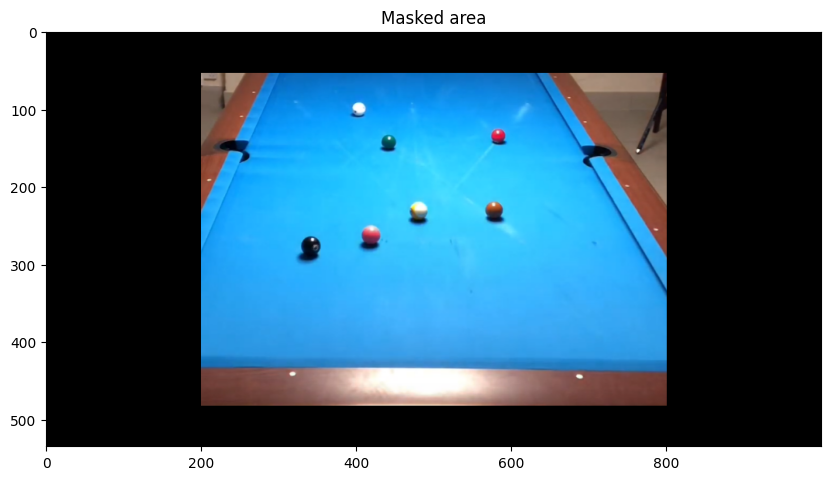

Most common HSV: (102, 198, 255)


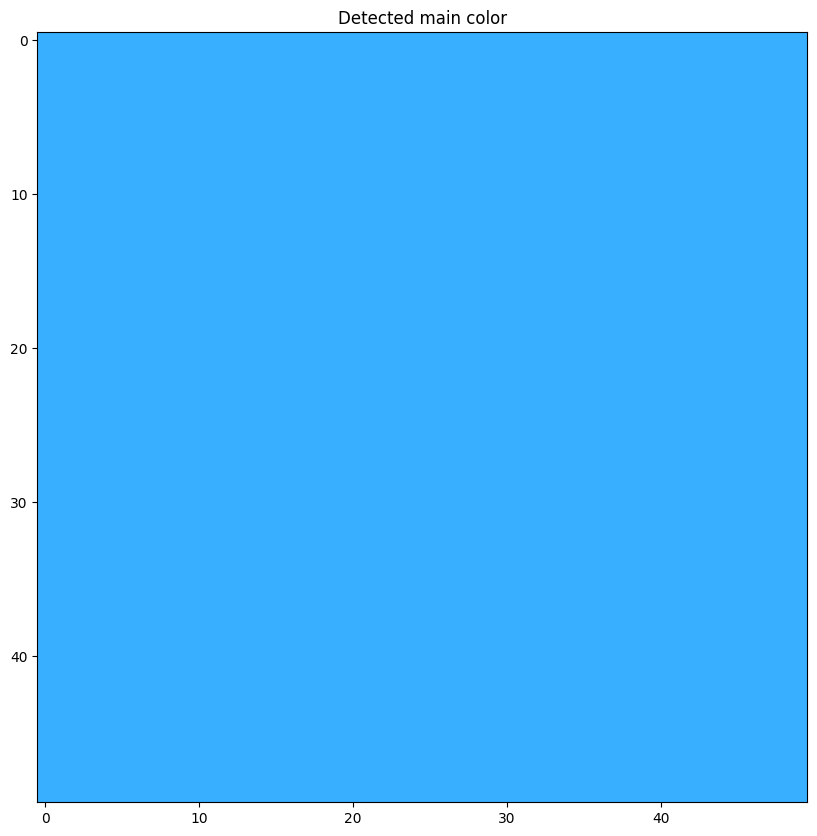

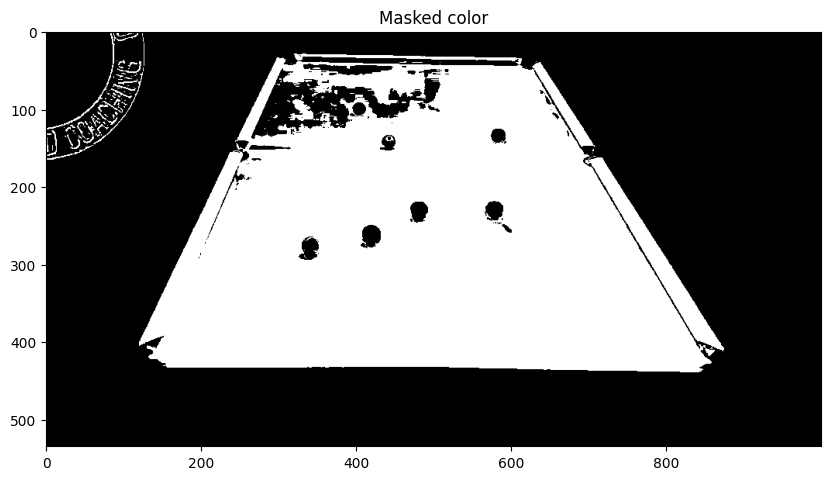

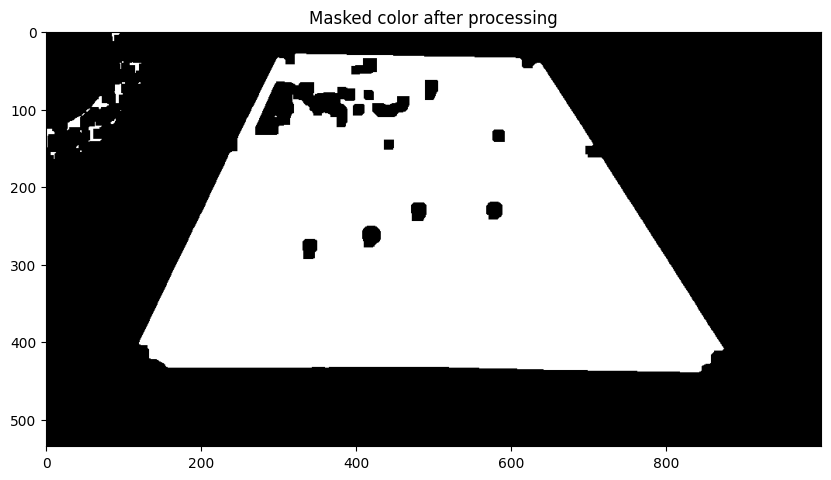

Hello3
Hello3
Hello3
Hello3


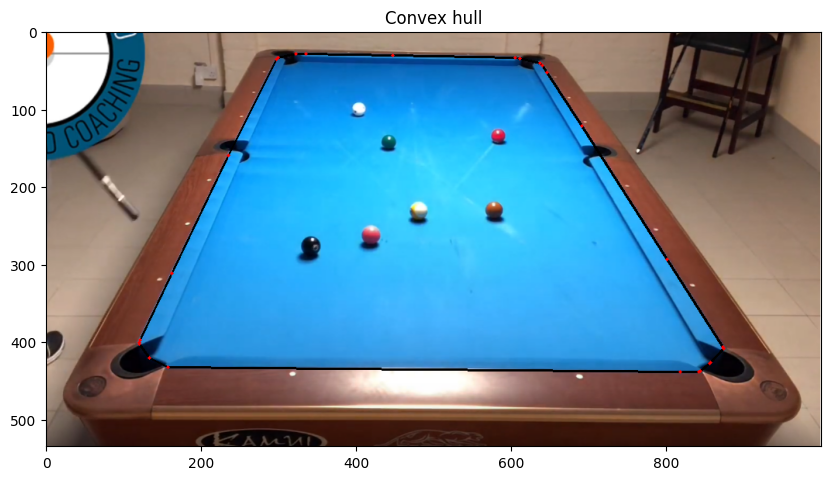

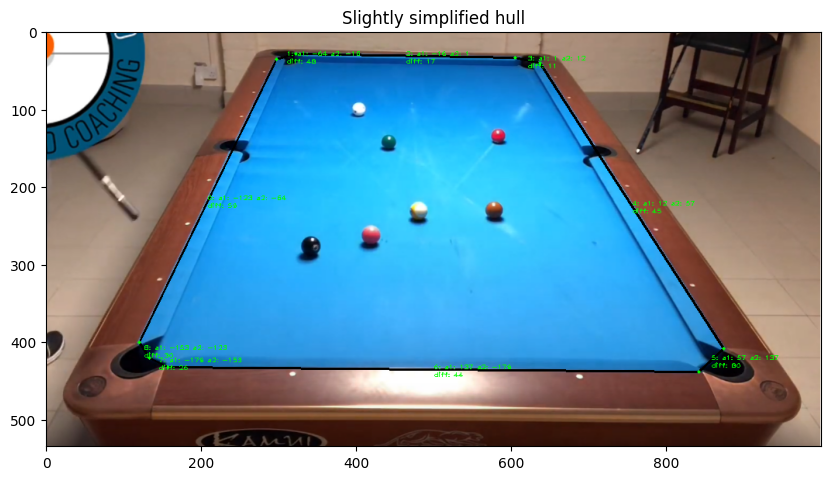

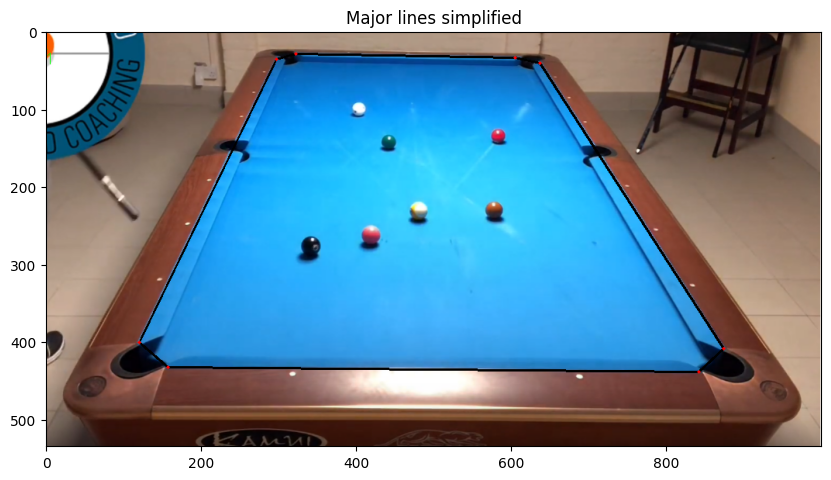

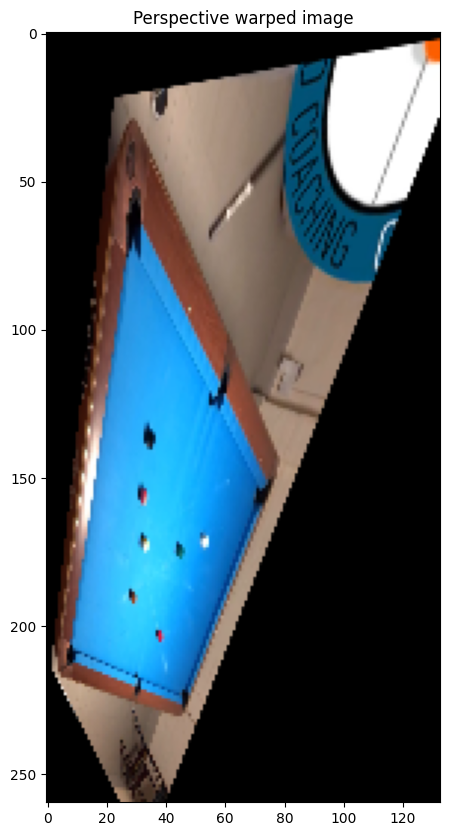

In [1]:
import math
import cv2
import indexer
import numpy as np
from plotter import plot_image
from geometry import line_intersection_point_matrix_solver, line_intersection_point_algebra
from matplotlib import pyplot as plt
from stopwatch import Stopwatch

PLAY_AREA_LENGTH = 254.0
PLAY_AREA_WIDTH = 127.0
CUSHION_DEPTH = 3.175
CLOTH_AREA_LENGTH = (PLAY_AREA_LENGTH + 2.0 * CUSHION_DEPTH)
CLOTH_AREA_WIDTH = (PLAY_AREA_WIDTH + 2.0 * CUSHION_DEPTH)
TABLE_SHAPE = np.float32([[0,0], [CLOTH_AREA_WIDTH, 0], [CLOTH_AREA_WIDTH, CLOTH_AREA_LENGTH], [0, CLOTH_AREA_LENGTH]]) 

def main():
    img = cv2.imread('pooltable1.png')
    h1, w1, _ = img.shape
    img = cv2.resize(img, (1000, round(h1 * (1000 / w1))))
    h, w, _ = img.shape
    lower_color, upper_color = detect_cloth_color(img)
    contours = get_cloth_contours(img, lower_color, upper_color)
    largest_contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(largest_contour)
    epsilon = cv2.arcLength(hull, True) * 0.001
    approx_hull = cv2.approxPolyDP(hull, epsilon, True)
    simplified_lines = simplify_hull_lines(approx_hull)
    intersections = calculate_corner_intersections(simplified_lines)
    intersections_np = np.float32(intersections)
    perspective_mat = cv2.getPerspectiveTransform(intersections_np, TABLE_SHAPE + np.float32([0, 0]))
    warped_img = cv2.warpPerspective(img.copy(), perspective_mat, ((int(CLOTH_AREA_WIDTH)), (int(CLOTH_AREA_LENGTH))), flags=cv2.INTER_LINEAR)
    with_contours = cv2.drawContours( 
        img.copy(), [largest_contour], -1, (0, 0, 0), 2)

    with_hull = cv2.drawContours(
        img.copy(), [hull], -1, (0, 0, 0), 2)
    for i in range(0, hull.shape[0]):
        cv2.circle(with_hull, hull[i][0], 2, (0, 0, 255), -1)

    with_largest_contour_approx = cv2.drawContours(
        img.copy(), [approx_hull], -1, (0, 0, 0), 2)

    for i in range(0, approx_hull.shape[0]):
        prev_point = approx_hull[(i-1) % approx_hull.shape[0]][0]
        point = approx_hull[i % approx_hull.shape[0]][0]
        next_point = approx_hull[(i+1) % approx_hull.shape[0]][0]

        vec1 = point - prev_point
        vec2 = next_point - point

        angle1 = math.atan2(vec1[1], vec1[0]) * 180.0 / np.pi
        angle2 = math.atan2(vec2[1], vec2[0]) * 180.0 / np.pi
        angle_diff = calc_angle_distance(angle1, angle2)

        mid = (point + next_point) / 2
        mid = [round(mid[0]), round(mid[1])]

        color = (0, 255, 0)
        if (angle_diff < 8):
            color = (255, 0, 0)

        cv2.putText(with_largest_contour_approx,
                    f"{i}: a1: {round(angle1)} a2: {round(angle2)}", mid, fontFace=1, fontScale=0.6, color=(0, 255, 0))
        cv2.putText(with_largest_contour_approx,
                    f"diff: {round(angle_diff)}", [mid[0], mid[1] + 10], fontFace=1, fontScale=0.6, color=(0, 255, 0))
        cv2.circle(with_largest_contour_approx, point, 2, color, -1)

    with_major_lines = cv2.drawContours(
        img.copy(), [simplified_lines], -1, (0, 0, 0), 2)

    for p in simplified_lines:
        point = p[0]
        cv2.circle(with_major_lines, point, 2, (0, 0, 255), -1)

    for i, p in enumerate(intersections):
        point = [round(p[0]), round(p[1])]
        cv2.circle(with_major_lines, point, 4, (0, 255, 0), -1)
        cv2.putText(with_major_lines,
                    f"{i}", [point[0], point[1] + 20], fontFace=1, fontScale=1.5, color=(0, 255, 0))

    plot_image(with_hull, "Convex hull")
    plot_image(with_largest_contour_approx, "Slightly simplified hull")
    plot_image(with_major_lines, "Major lines simplified")
    plot_image(warped_img, "Perspective warped image")


def calculate_corner_intersections(hull_lines):
    intersections = []
    prev_point = None
    prev_direction = None
    num_pts = hull_lines.shape[0]
    for i in range(num_pts + 2):
        curr_point = hull_lines[i % num_pts][0]
        next_point = hull_lines[(i + 1) % num_pts][0]
        curr_direction = next_point - curr_point

        len = np.linalg.norm(curr_direction)
        if (len < 100):
            continue

        if (prev_point is None):
            prev_point = curr_point
            prev_direction = curr_direction
            continue

        intersection = line_intersection_point_matrix_solver(prev_point, prev_direction, curr_point, curr_direction)
        if (intersection is not None):
            intersections.append(intersection)
        prev_point = curr_point
        prev_direction = curr_direction

    return intersections

def simplify_hull_lines(hull):
    points = []
    for i in range(hull.shape[0]):
        prev_point = hull[(i-1) % hull.shape[0]][0]
        point = hull[i % hull.shape[0]][0]
        next_point = hull[(i+1) % hull.shape[0]][0]

        vec1 = point - prev_point
        vec2 = next_point - point

        angle1 = math.atan2(vec1[1], vec1[0]) * 180.0 / np.pi
        angle2 = math.atan2(vec2[1], vec2[0]) * 180.0 / np.pi
        len1 = np.linalg.norm(vec1)
        len2 = np.linalg.norm(vec2)
        total_len = len1 + len2

        angle_diff = calc_angle_distance(angle1, angle2)
        if (angle_diff > 7 and total_len > 70):
            points.append([point])
    return np.array(points)


def calc_angle_distance(angle1, angle2):
    delta = angle2 - angle1
    if (delta > 180):
        delta = delta - 360
    if (delta < -180):
        delta = delta + 360
    return delta


def detect_cloth_color(img, hue_width=55, sat_width=45, val_width=210):
    """
    Find the most common HSV values in the image.
    In a well lit image, this will be the cloth
    """
    hsv = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV)
    h, w, _ = hsv.shape
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    cv2.rectangle(mask, (round(0.2*w), round(0.1*h)),
                  (round(0.8*w), round(0.9*h)), (255, 255, 255), -1)


    plot_image(cv2.bitwise_and(img, img, mask=mask), "Masked area")


    hist = cv2.calcHist([hsv], [0], mask, [180], [0, 180])
    h_max = indexer.get_index_of_max(hist)[0]

    hist = cv2.calcHist([hsv], [1], mask, [256], [0, 256])
    s_max = indexer.get_index_of_max(hist)[0]

    hist = cv2.calcHist([hsv], [2], mask, [256], [0, 256])
    v_max = indexer.get_index_of_max(hist)[0]


    hsv_max = (h_max, s_max, v_max)
    print(f"Most common HSV: {hsv_max}")

    # Display main HSV as color
    color_image = np.zeros((50, 50, 3), np.uint8)
    color_image[:] = hsv_max
    color_image = cv2.cvtColor(color_image, cv2.COLOR_HSV2BGR)
    plot_image(color_image, "Detected main color")


    # Range bounds for detected main color
    lower_color = np.array(
        [h_max-hue_width, s_max-sat_width, v_max-val_width])
    upper_color = np.array(
        [h_max+hue_width, s_max+sat_width, v_max+val_width])

    return lower_color, upper_color


def get_cloth_contours(img, lower_color, upper_color, filter_radius=5):
    hsv = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV)

    """
    Returns the contours generated from the given color range
    """

    # Threshold the HSV image to get only cloth colors
    mask = cv2.inRange(hsv, lower_color, upper_color)

    plot_image(mask, "Masked color")
    # use a median filter to get rid of speckle noise
    median = cv2.medianBlur(mask, filter_radius)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(median, kernel, iterations=5)
    shrunk = cv2.erode(dilated, kernel, iterations=5)
    plot_image(shrunk, "Masked color after processing")

    contours, hierarchy = cv2.findContours(
        shrunk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return contours


main()
